Uploading Dataset

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samamobtasemellamey","key":"4f19726890d5cd5c93893aabab2d6afc"}'}

In [4]:
import os
import zipfile
# Make kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)
# Move kaggle.json
!mv kaggle.json /root/.kaggle/
# Change permissions
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 75% 111M/149M [00:00<00:00, 1.15GB/s]
100% 149M/149M [00:00<00:00, 930MB/s] 


In [6]:
with zipfile.ZipFile("brain-tumor-mri-dataset.zip","r") as z:
    z.extractall("brain_tumor_dataset")

Data Preparation and Preprocessing

In [7]:
import sys
import configparser
import time
from math import ceil

# Reading and setup data
import cv2
import imutils
from tqdm import tqdm

# Loading datasets
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
import tensorflow as tf
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [9]:
train_dir = "brain_tumor_dataset/Training"
print("Subfolders inside Training:")
print(os.listdir(train_dir))

Subfolders inside Training:
['notumor', 'meningioma', 'glioma', 'pituitary']


Exploring Data

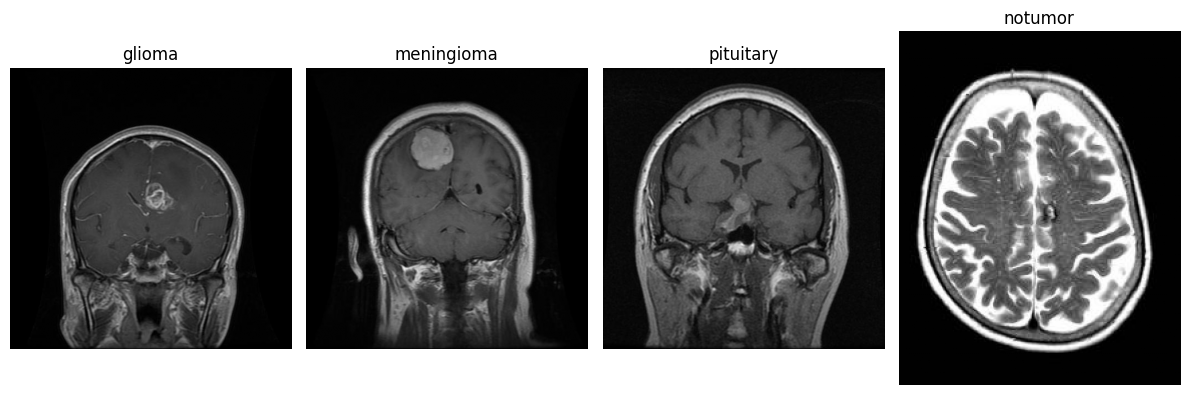

In [10]:
train_dir = "brain_tumor_dataset/Training"
categories = ["glioma", "meningioma", "pituitary", "notumor"]

plt.figure(figsize=(12, 4))

for i, category in enumerate(categories):
    class_folder = os.path.join(train_dir, category)
    files = os.listdir(class_folder)

    img_path = os.path.join(class_folder, files[0])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(category)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
import shutil
import random
from collections import Counter
# Paths
original_train_dir = "brain_tumor_dataset/Training"
original_test_dir  = "brain_tumor_dataset/Testing"
new_base_dir       = "brain_tumor_dataset_split"
train_dir          = os.path.join(new_base_dir, "train")
valid_dir          = os.path.join(new_base_dir, "valid")
test_dir           = os.path.join(new_base_dir, "test")
# Create new folders
for d in [train_dir, valid_dir, test_dir]:
    os.makedirs(d, exist_ok=True)
# Copy test folder as-is
shutil.copytree(original_test_dir, test_dir, dirs_exist_ok=True)
# Split Training into train + validation
for class_name in os.listdir(original_train_dir):
    class_path = os.path.join(original_train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    valid_images = images[split_idx:]

    # Create class folders in new train/valid dirs
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, class_name), exist_ok=True)

    # Copy files
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in valid_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_dir, class_name, img))

# Function to count images per class
def count_images(base_dir):
    data = []
    for category in os.listdir(base_dir):
        folder = os.path.join(base_dir, category)
        if os.path.isdir(folder):
            count = len(os.listdir(folder))
            data.append([base_dir.split("/")[-1], category, count])
    return data

import pandas as pd

train_data = count_images(train_dir)
valid_data = count_images(valid_dir)
test_data  = count_images(test_dir)

df = pd.DataFrame(train_data + valid_data + test_data, columns=["Split", "Class", "Count"])
print(df)

    Split       Class  Count
0   train     notumor   1276
1   train  meningioma   1071
2   train      glioma   1056
3   train   pituitary   1165
4   valid     notumor    319
5   valid  meningioma    268
6   valid      glioma    265
7   valid   pituitary    292
8    test     notumor    405
9    test  meningioma    306
10   test      glioma    300
11   test   pituitary    300


Resizing And Normalizing Data

In [12]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Force 1 channel
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Apply this transform to the datasets
train_set = datasets.ImageFolder(train_dir, transform=transform)
valid_set = datasets.ImageFolder(valid_dir, transform=transform)
test_set  = datasets.ImageFolder(original_test_dir,  transform=transform)

# Test first image
img_train, label_train = train_set[0]
print("Train image type:", type(img_train))
print("Train image size:", img_train.shape)

img_valid, label_valid = valid_set[0]
print("Valid image type:", type(img_valid))
print("Valid image size:", img_valid.shape)

Train image type: <class 'torch.Tensor'>
Train image size: torch.Size([1, 128, 128])
Valid image type: <class 'torch.Tensor'>
Valid image size: torch.Size([1, 128, 128])


In [13]:
print(img_train.min(), img_train.max())

tensor(0.) tensor(0.8078)


In [15]:
print(img_valid.min(), img_valid.max())

tensor(0.) tensor(0.6039)


Data Augmentation

In [16]:
random_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=random_transform)

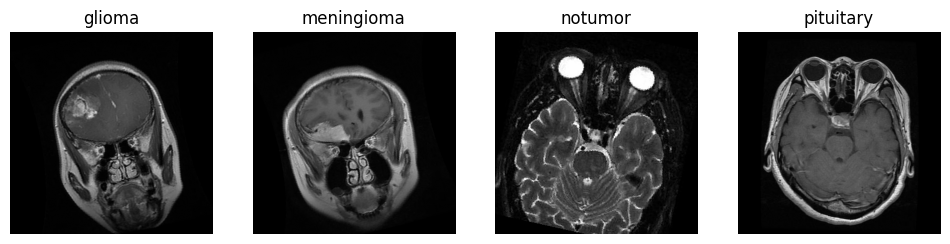

In [17]:
def imshow(img_tensor, ax, title=None):
    img = img_tensor[0, :, :]  # remove the single channel dimension
    ax.imshow(img, cmap='gray')
    if title:
        ax.set_title(title)
    ax.axis('off')

fig, axes = plt.subplots(1, 4, figsize=(12,3))
displayed_classes = set()
i = 0

for img, label in train_dataset:
    class_name = train_dataset.classes[label]
    if class_name not in displayed_classes:
        imshow(img, axes[i], title=class_name)
        displayed_classes.add(class_name)
        i += 1
    if i == 4:
        break

plt.show()